In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import k_clique_communities
import networkx.algorithms.community as nx_comm
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import itertools
import numpy as np
import infomap
from infomap import Infomap
import pandas as pd
from utils import *

# Worm cortex Graph community detection. 
#####  https://neurodata.io/project/connectomes/


In [44]:
# Read in graph
G = nx.read_graphml('../Datasets/c.elegans.herm_pharynx_1.graphml')
print(f"{G.number_of_edges()} edges and {G.number_of_nodes()} nodes")

cell_name_attr = nx.get_node_attributes(G,'cell_name').values()
role_attr = nx.get_node_attributes(G,'role').values()
cell_class_attr = nx.get_node_attributes(G,'cell_class').values()
neuro_attr = nx.get_node_attributes(G,'neurotransmitters').values()
soma_attr = nx.get_node_attributes(G,'soma_pos').values()


# create pandas dataframe for analysis of metadata
df = pd.DataFrame({'cell name':cell_name_attr,'role':role_attr, 'cell class':cell_class_attr,'neurtransmitters':neuro_attr,'soma_pos':soma_attr})

print(len(df["neurtransmitters"].value_counts()))

# role has 3 classes and neurtransmitters has 7. These could relate to communities.

# nx.draw(G, edge_color='b',  with_labels=True,
#             font_weight='light', node_size= 10, width= 0.5)

3225 edges and 279 nodes
7


# Girvan Newman 
##### Invesitigate how modularity changes as more disconections are made and more communities are found

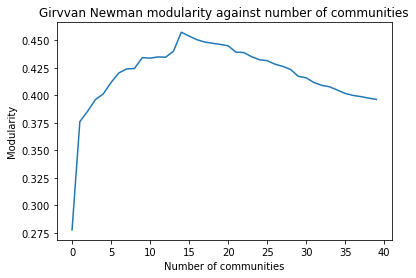

CPU times: user 14 s, sys: 59.6 ms, total: 14.1 s
Wall time: 13.9 s


In [3]:
%%time
# Algorithm 1. Girvan Newman 
partition_girvan_newman = girvan_newman(G)
k = 40 # Check 39 partitions

mod_list = []
for communities in itertools.islice(partition_girvan_newman, k):
    partitions = tuple(sorted(c) for c in communities)
    # Use modularity to check partition
    GN_mod = nx_comm.modularity(G,partitions)
    mod_list.append(GN_mod)

# plot partitions with k to optimize modularity
plt.plot(mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Girvvan Newman modularity against number of communities")
plt.show()

##### Check modularity with apriori knowledge of 3 communities from the ground truth

3 communities detected
The modularity is 0.376


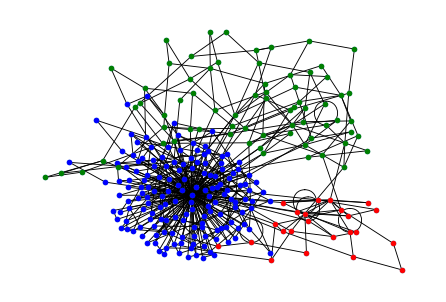

CPU times: user 5.37 s, sys: 63.6 ms, total: 5.43 s
Wall time: 5.29 s


In [4]:
%%time 
partition_girvan_newman = girvan_newman(G)
k=2 # if we have apriori knowledge of 3 groudn truth communities:
for communities in itertools.islice(partition_girvan_newman, k):
    partitions = tuple(sorted(c) for c in communities)

GN_mod = nx_comm.modularity(G,partitions)
print(f"{len(partitions)} communities detected")
print(f"The modularity is {GN_mod:.3}")
presentCommunities(G,partitions)

# Infomap
#####  https://github.com/mapequation/infomap

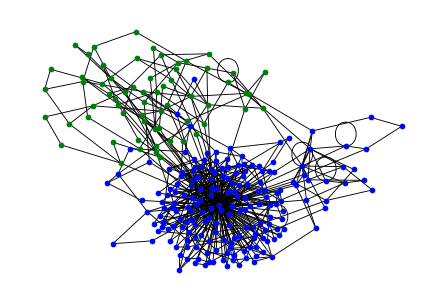

2 communities detected
The modularity is 0.26
CPU times: user 396 ms, sys: 60.1 ms, total: 456 ms
Wall time: 186 ms


In [5]:
%%time
# Algorithm 2. k infomap

im = Infomap(silent=True)
im.add_networkx_graph(G)
im.run()

partition = [[] for _ in range(im.num_top_modules)]
for node in im.tree:
    if node.is_leaf:
        partition[node.module_id-1].append(node.node_id)

# Need to decide when to stop removing edges.
presentCommunities(G,partition)

info_mod = nx_comm.modularity(G,tuple(partition))
print(f"{len(partition)} communities detected")
print(f"The modularity is {info_mod:.3}")

# Spectral Clustering

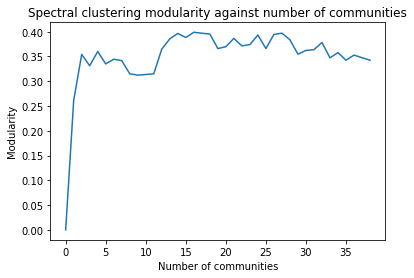

CPU times: user 1min 20s, sys: 52.1 s, total: 2min 12s
Wall time: 27.8 s


In [6]:
%%time
# Algorithm 3. Spectral clustering

# Get adjacency-matrix as numpy-array
sc_mod_list = []
for k in range(1,40):
    adj_mat = nx.to_numpy_matrix(G)
    # Cluster
    sc = SpectralClustering(k, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    partition_labels = sc.labels_.tolist()
    # Turn back into partition data structure ([],[],[]...)
    # position in list is node number value is community id

    partition = [[] for _ in range(max(partition_labels)+1)]
    for idx,c in enumerate(partition_labels):
        partition[c].append(idx)

    sc_mod = nx_comm.modularity(G,tuple(partition))
    sc_mod_list.append(sc_mod)

# Plot modularity for increasing community number
plt.plot(sc_mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Spectral clustering modularity against number of communities")
plt.show()

##### With apriori knowledge of ground truth community number k = 3

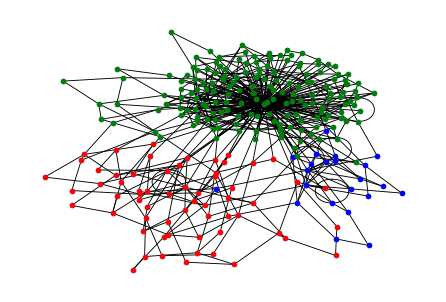

3 communities detected
The modularity is 0.354
CPU times: user 687 ms, sys: 330 ms, total: 1.02 s
Wall time: 343 ms


In [7]:
%%time
k=3
# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G)
# Cluster
sc = SpectralClustering(k, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

partition_labels = sc.labels_.tolist()
# Turn back into partition data structure ([],[],[]...)
# position in list is node number value is community id

partition = [[] for _ in range(max(partition_labels)+1)]
for idx,c in enumerate(partition_labels):
    partition[c].append(idx)

# Need to decide when to stop removing edges.
presentCommunities(G,partition)

sc_mod = nx_comm.modularity(G,tuple(partition))
print(f"{len(partition)} communities detected")
print(f"The modularity is {sc_mod:.3}")

# Analysis

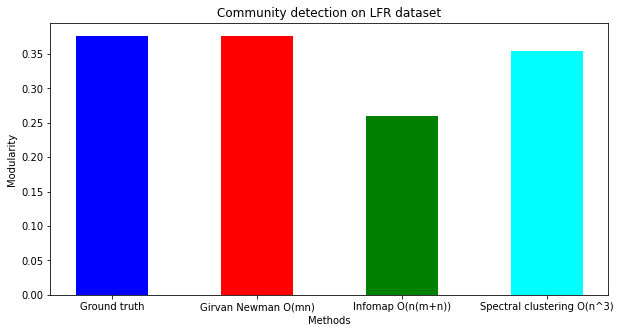

In [8]:
# Compare methods
data = {'Ground truth':ground_truth_mod, 'Girvan Newman O(mn)':GN_mod, 'Infomap O(n(m+n))':info_mod,
        'Spectral clustering O(n^3)':sc_mod}
method = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, values,
        width = 0.5, color=['blue', 'red', 'green', 'cyan'])
 
plt.xlabel("Methods")
plt.ylabel("Modularity")
plt.title("Community detection on LFR dataset")
plt.show()

In [ ]:
# Measure overlap of found communities with node class metadata